# Includes Channel and Batch

Coded by Lujia Zhong @lujiazho<br>
Reference: https://microsoft.github.io/ai-edu/

In [1]:
!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/lujiazho/MachineLearningPlayground.git

Cloning into 'MachineLearningPlayground'...
remote: Enumerating objects: 234, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 234 (delta 69), reused 118 (delta 38), pack-reused 65
Receiving objects: 100% (234/234), 25.36 MiB | 28.66 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [3]:
%cd MachineLearningPlayground/

/content/MachineLearningPlayground


In [4]:
import time
import pickle
import numba as nb
import numpy as np
import matplotlib.pyplot as plt

from miniml.ann import *
from miniml.ann.common import *
from miniml.ann.utils import *

In [7]:
with open('../data_batch_1', 'rb') as fo:
    dict_ = pickle.load(fo, encoding='bytes')
with open('../batches.meta', 'rb') as fo:
    meta = pickle.load(fo, encoding='bytes')

data, labels = dict_[b'data'], dict_[b'labels']
names = meta[b'label_names']
len(data), len(labels)

(10000, 10000)

b'ship'


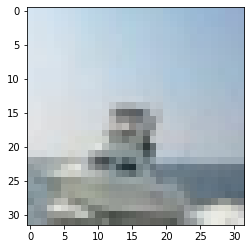

In [8]:
idx = 100
img = data[idx].reshape(3,32,32)
print(names[labels[idx]])
_ = plt.imshow(img.transpose(1,2,0))

In [9]:
@nb.jit(nopython=True)
def loop_img2col(k, s, n_h, n_w, col, inputs):
    for i in range(k):
        i_max = i + s*n_h
        for j in range(k):
            j_max = j + s*n_w
            col[:, :, i, j, :, :] = inputs[:, :, i:i_max:s, j:j_max:s]

def img2col(inputs, n_h, n_w, k, s=1):
    bt, c_i = inputs.shape[0:2] 

    # [bt, c_i, k, k, n_h, n_w]
    col = np.zeros((bt, c_i, k, k, n_h, n_w))
    loop_img2col(k, s, n_h, n_w, col, inputs)

    # [bt, c_i, k, k, n_h, n_w] -> [bt*n_h*n_w, k*k*c_i]
    col = np.transpose(col, axes=(0, 4, 5, 1, 2, 3)).reshape(bt*n_h*n_w, -1)
    return col

@nb.jit(nopython=True)
def loop_col2img(k, s, n_h, n_w, img, tmp2):
    for i in range(k):
        i_max = i + s*n_h
        for j in range(k):
            j_max = j + s*n_w
            img[:, :, i:i_max:s, j:j_max:s] += tmp2[:, :, i, j, :, :]

def col2img(grad_col_x, input_shape, k, s, shift, n_h, n_w):
    bt, c_i, h, w = input_shape

    # [bt*n_h*n_w, k*k*c_i] -> [bt, n_h, n_w, c_i, k, k]
    tmp1 = grad_col_x.reshape(bt, n_h, n_w, c_i, k, k)
    # [bt, n_h, n_w, c_i, k, k] -> [bt, c_i, k, k, n_h, n_w]
    tmp2 = np.transpose(tmp1, axes=(0, 3, 4, 5, 1, 2))

    img = np.zeros((bt, c_i, h + 2*shift + s - 1, w + 2*shift + s - 1))
    loop_col2img(k, s, n_h, n_w, img, tmp2)

    # grad_x: [bt, c_i, h, w]
    return img[:, :, shift:h + shift, shift:w + shift]

In [10]:
class Conv2D(Node):
    def __init__(self, nodes, weights, bias, output_c, input_c, stride=1, padding=False):
        self.output_c = output_c
        self.input_c = input_c
        self.stride = stride
        self.padding = padding
        self.bias = True if bias else False
        Node.__init__(self, [nodes, weights, bias] if bias else [nodes, weights])

    def forward(self):
        # inputs: [batch, channel_in, hight_in, width_in]
        inputs = self.inputs[0].value
        # weights: [channel_out, channel_in, kernel_size, kernel_size]
        weights = self.inputs[1].value
        # bias: [channel_out, 1, 1] or [1, channel_out, 1, 1] is the same
        if self.bias:
            bias = self.inputs[2].value
        k = weights.shape[2]  # kernel size (w equals to h)

        s = self.stride
        if self.padding:
            inputs = np.pad(inputs, ((0,0),(0,0),(k//2,k//2),(k//2,k//2)), 'constant')
        assert (inputs.shape[2]-k)%s == 0
        assert (inputs.shape[3]-k)%s == 0
        assert s < k

        self.new_h = (inputs.shape[2]-k)//s+1
        self.new_w = (inputs.shape[3]-k)//s+1

        self.col_x = img2col(inputs, self.new_h, self.new_w, k, s=s)
        self.col_kernel = weights.reshape(self.output_c, -1).T
        if self.bias:
            col_bias = bias.reshape(1, self.output_c)
        
        col_res = np.dot(self.col_x, self.col_kernel) + (col_bias if self.bias else 0)
        tmpres = col_res.reshape(inputs.shape[0], self.new_h, self.new_w, self.output_c)
        self.value = np.transpose(tmpres, axes=(0,3,1,2))
    
    def backward(self):
        # create zero loss for all inputs
        self.gradients = {n: np.zeros_like(n.value, dtype=np.float64) for n in self.inputs}
        
        c_i = self.input_c
        c_o = self.output_c
        s = self.stride
        k = self.inputs[1].value.shape[2]
        
        # X: [batch, ch_in, height_in, width_in]
        X = self.inputs[0].value

        for n in self.outputs:
            # Get the cost w.r.t this node.
            grad_y = n.gradients[self]
            
            grad_col_res = np.transpose(grad_y, axes=(0,2,3,1)).reshape(-1, c_o)
            
            # grad_col_bias: [1, c_o]
            grad_col_bias = np.sum(grad_col_res, axis=0, keepdims=True)
            # grad_col_kernel: [k*k*c_i, c_o]
            grad_col_kernel = np.dot(self.col_x.T, grad_col_res)
            # grad_col_x: [bt*n_h*n_w, k*k*c_i]
            grad_col_x = np.dot(grad_col_res, self.col_kernel.T)
            
            if self.bias:
                self.gradients[self.inputs[2]] += grad_col_bias.reshape(c_o, 1, 1)
            
            self.gradients[self.inputs[1]] += np.transpose(grad_col_kernel, axes=(1, 0)).reshape(c_o, c_i, k, k)
            
            self.gradients[self.inputs[0]] += col2img(grad_col_x, X.shape, k, s, 
                                                      k//2 if self.padding else 0, self.new_h, self.new_w)

In [11]:
class AvePooling(Node):
    def __init__(self, nodes, k=3):
        self.k = k
        Node.__init__(self, [nodes])
    
    def forward(self):
        inputs = self.inputs[0].value
        s = k = self.k
        
        assert inputs.shape[2]%k == 0
        assert inputs.shape[3]%k == 0
        assert k > 1

        self.new_h = inputs.shape[2]//k
        self.new_w = inputs.shape[3]//k
        
        bt, c_io = inputs.shape[:2]
        # [bt*n_h*n_w, c_i*k*k]
        col = img2col(inputs, self.new_h, self.new_w, k, s)
        # [bt*n_h*n_w*c_i, k*k]
        col_x = col.reshape(-1, k*k)
        # [bt*n_h*n_w*c_i, k*k] -> [bt*n_h*n_w*c_i] -> [bt, n_h, n_w, c_i]
        out = np.mean(col_x, axis=1).reshape(bt, self.new_h, self.new_w, c_io)
        # [bt, n_h, n_w, c_i] -> [bt, c_i, n_h, n_w]
        self.value = np.transpose(out, axes=(0,3,1,2))
    
    def backward(self):
        # create zero loss for all inputs
        self.gradients = {n: np.zeros_like(n.value, dtype=np.float64) for n in self.inputs}
        s = k = self.k
        X = self.inputs[0].value

        for n in self.outputs:
            # Get the cost w.r.t this node.
            grad_y = n.gradients[self]
            
            # c_i==c_o, [bt, c_i, n_h, n_w] -> [bt, n_h, n_w, c_i]
            tmp = np.transpose(grad_y, (0,2,3,1))
            # [bt, n_h, n_w, c_i] -> [bt*n_h*n_w*c_i, k*k]
            grad = np.repeat(tmp.flatten(), k*k)/k*k
            # [bt*n_h*n_w*c_i, k*k] -> [bt, n_h, n_w, c_i, k*k]
            grad = grad.reshape(tmp.shape + (k*k,))
            # [bt, n_h, n_w, c_i, k*k] -> [bt*n_h*n_w, c_i*k*k]
            grad = grad.reshape(grad.shape[0] * grad.shape[1] * grad.shape[2], -1)
            
            self.gradients[self.inputs[0]] += col2img(grad, X.shape, k, s, 0, self.new_h, self.new_w)

In [12]:
class Flatten(Node):
    def __init__(self, nodes):
        Node.__init__(self, [nodes])
        
    def forward(self):
        inputs = self.inputs[0].value
        self.value = inputs.flatten().reshape(inputs.shape[0],-1)
    
    def backward(self):
        # create zero loss for all inputs
        self.gradients = {n: np.zeros_like(n.value, dtype=np.float64) for n in self.inputs}
        X = self.inputs[0].value

        for n in self.outputs:
            # Get the cost w.r.t this node.
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] += grad_cost.reshape(X.shape)

In [16]:
W1 = np.random.randn(6, 3, 5, 5)
b1 = np.random.randn(6, 1, 1)

W2 = np.random.randn(16, 6, 5, 5)
b2 = np.random.randn(16, 1, 1)

W3 = np.random.randn(400, 120)
b3 = np.random.randn(120)

W4 = np.random.randn(120, 84)
b4 = np.random.randn(84)

W5 = np.random.randn(84, 10)

x_node, y_node = Placeholder(), Placeholder()

W1_node = Placeholder()
b1_node = Placeholder()

W2_node = Placeholder()
b2_node = Placeholder()

W3_node = Placeholder()
b3_node = Placeholder()

W4_node = Placeholder()
b4_node = Placeholder()

W5_node = Placeholder()

conv1 = Conv2D(x_node, W1_node, b1_node, output_c=6, input_c=3, stride=1, padding=False)
ave1 = AvePooling(conv1, k=2)
conv2 = Conv2D(ave1, W2_node, b2_node, output_c=16, input_c=6, stride=1, padding=False)
ave2 = AvePooling(conv2, k=2)
flat = Flatten(ave2)
l1 = Linear(flat, W3_node, b3_node)
sigmoid1 = Sigmoid(l1)
l2 = Linear(sigmoid1, W4_node, b4_node)
sigmoid2 = Sigmoid(l2)
l3 = Linear(sigmoid2, W5_node, None)
sigmoid3 = Sigmoid(l3)
mse = MSE(y_node, sigmoid3)

In [17]:
feed_dict = {
    x_node: np.array([img]),
    y_node: np.array([0,1,0,0,0,0,0,0,0,0]),

    W1_node: W1,
    b1_node: b1,

    W2_node: W2,
    b2_node: b2,
    
    W3_node: W3,
    b3_node: b3,
    
    W4_node: W4,
    b4_node: b4,
    
    W5_node: W5
}

graph = feed_dict_2_graph(feed_dict)    # network graph
sorted_graph = topology(graph)          # sorted graph
trainables = [W1_node, b1_node, W2_node, b2_node, W3_node, b3_node, W4_node, b4_node, W5_node]

In [18]:
start_time = time.time()
optimizer = 'Adam'
lr = 1e-2
epochs = 20
batch = 2

# only used for Adam
it = 0

for i in range(1, epochs+1):
    it += 1
    losses = []
    for j in range(1, 100, batch):
        # Step 4.1: sample a batch of examples and Reset value
        x_node.value = data[j:j+batch].reshape(batch, 3, 32, 32)
        y_node.value = np.eye(10)[labels[j:j+batch]].reshape(batch,-1)

        # Step 4.2: forward
        for n in sorted_graph:
            n.forward()

        # Step 4.3: backward
        for n in sorted_graph[::-1]:
            n.backward()

        # Step 4.4: optimization
        for t in trainables:
            t.optimize(optimizer=optimizer, lr=lr, it=it)

        # Step 5: update current loss
        loss = sorted_graph[-1].value
        
        losses.append(loss)

    if (i+1) % 1 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(i, np.mean(losses)))
print(f"{((time.time() - start_time)/epochs):.4f} sec/epoch")

Epoch: 1, Loss: 0.1293
Epoch: 2, Loss: 0.1000
Epoch: 3, Loss: 0.0999
Epoch: 4, Loss: 0.0995
Epoch: 5, Loss: 0.1000
Epoch: 6, Loss: 0.1000
Epoch: 7, Loss: 0.1000
Epoch: 8, Loss: 0.1000
Epoch: 9, Loss: 0.1000
Epoch: 10, Loss: 0.0999
Epoch: 11, Loss: 0.0999
Epoch: 12, Loss: 0.0999
Epoch: 13, Loss: 0.0999
Epoch: 14, Loss: 0.0998
Epoch: 15, Loss: 0.0995
Epoch: 16, Loss: 0.0989
Epoch: 17, Loss: 0.0983
Epoch: 18, Loss: 0.0976
Epoch: 19, Loss: 0.0968
Epoch: 20, Loss: 0.0960
0.6973 sec/epoch


In [19]:
preds = []
reals = []
for i in range(1):
    x_node.value = np.array(data[i:i+1000]).reshape(1000, 3, 32, 32)
    for n in sorted_graph[:-1]:
        n.forward()
    preds.append(np.argmax(sorted_graph[-2].value, axis=1))
    reals.append(labels[i:i+1000])
print(np.sum(np.array(preds)==np.array(reals))/1000)

0.119
